In [64]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import glob
from scipy.optimize import minimize
import emcee
import corner
import re

sns.set_theme(context='notebook', style='whitegrid', palette='dark')
#ignrore warnings
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [65]:
def parse_data_file(file_path):
    data = {}
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            # Match key-value pairs (e.g., 'key value')
            match = re.match(r"#?\s*([\w]+)\s+([\d\.\-\+Ee]+|\-?\d+\.\d+)", line)
            if match:
                key = match.group(1)
                value = match.group(2)
                # Convert numeric values to float or int
                if re.match(r"^\-?\d+\.\d+$", value):
                    value = float(value)
                elif re.match(r"^\-?\d+$", value):
                    value = int(value)
                data[key] = value
            # Handle special cases (e.g., background with two values)
            if "background" in line:
                parts = line.split()
                try:
                    data['background'] = float(parts[2]), float(parts[3])
                except:
                    data['background'] = 1000, 0.0
    return data

def gaussian(x, mu, sig, height):
    return height*np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) / (sig*np.sqrt(2*np.pi))


def bgmodel(x, Bmax, xmax, beta):
    return Bmax*(x/xmax)**(beta)

# def model0(x, numax, Dnu, logheight, Bmax, beta):
#     bg = bgmodel(x, Bmax, numax, beta)
#     return 10**gaussian(np.log10(x), np.log10(numax), Dnu, logheight) * bg

def model(x, numax, sigma, height, Bmax, beta, phot):
    bg = bgmodel(x, Bmax, numax, beta)
    return gaussian(x, numax, sigma, height) + bg + phot

def nu(n, l, eps, alpha, nmax, Dnu, d02):
    if l == 0:
        d0l = 0
    elif l == 2:
        d0l = d02
    else:
        raise ValueError("l must be 0 or 2")
    return Dnu*(n + l/2 + eps + d0l + 0.5*alpha*(nmax - n)**2)

def lorrentzian(x, S, lw, x0):
    """
    x: frequency
    S: height
    x0: central frequency
    lw: line width
    """
    return S / (1 + 4*((x - x0) / lw)**2)

def l_peaks(x, h1, h2, lw1, lw2, Dnu, eps, alpha, d02, numax, n):
    ls = [0, 2]
    nmax = numax/Dnu - eps
    total_psd = 0
    total_psd += lorrentzian(x, h1, lw1, nu(n, ls[0], eps, alpha, nmax, Dnu, d02))
    total_psd += lorrentzian(x, h2, lw2, nu(n-1, ls[1], eps, alpha, nmax, Dnu, d02))
    return total_psd

In [66]:
figdir = 'figures/'

In [67]:
class spectrum:
    def __init__(self, path):
        self.path = path
        self.ID = os.path.basename(path).split(".")[0]
        self.data = pd.read_csv(path, delimiter="\s+", header=None, names=['frequency', 'PSD'], skiprows=21)
        self.header = parse_data_file(path)
        nn = self.header['numax']
        self.full_data = self.data.copy()
        self.data = self.data[(self.data['frequency'] > nn /10)]
        self.frequency = self.data['frequency'].values
        self.PSD = self.data['PSD'].values
        self.n = len(self.frequency)
        
    def plot_data(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.frequency, self.PSD)
        plt.xlabel("Frequency (µHz)")
        plt.ylabel("Power Spectral Density (ppm²/µHz)")
        plt.xscale("log")
        plt.yscale("log")
        # plt.legend()
        plt.savefig(figdir + self.ID + '_data.png')
        plt.show()
    def set_model(self, model, init_params):
        self.model = model
        self.init_params = init_params
    def plot_model(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.frequency, self.PSD, label="Data", color="black")
        plt.plot(self.frequency, self.model(self.frequency, *self.init_params), label="Model", color="red")
        plt.xlabel("Frequency (µHz)")
        plt.ylabel("Power Spectral Density (ppm²/µHz)")
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.show()
    def log_likelihood(self, params, x, y):
        y_mod = self.model(x, *params)
        y_err = np.mean(y) * 0.05
        if np.any(y_mod <= 0):
            return -np.inf
        return -np.sum(np.log(y_mod) + y / y_mod)
        # return -0.5 * np.sum((y - y_mod)**2 / y_err**2)
    
    def log_prior(self, params):
        numax, sigma, height, Bmax, beta, phot = params
        if 0 < numax and 0 < sigma < 20 and height > 0 and Bmax > 0:
            return 0.0  # Uniform prior
        return -np.inf  # Log probability is -inf if parameters are outside bounds
    def log_posterior(self, params, frequency, power_density):
        lp = self.log_prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood(params, frequency, power_density)
    def init_mcmc_bg(self):
        self.ndim = len(self.init_params)  # Number of parameters
        self.nwalkers = 32  # Number of walkers
        self.nsteps = 6000  # Number of steps
        # Initialize the walkers
        self.pos = self.init_params + 1e-4 * np.random.randn(self.nwalkers, self.ndim)
    def run_mcmc_bg(self):
        self.sampler = emcee.EnsembleSampler(self.nwalkers, self.ndim, self.log_posterior, args=(self.frequency, self.PSD))
        print("Running MCMC burn-in...")
        p0, _, _ = self.sampler.run_mcmc(self.pos, self.nsteps, progress=True)
        self.sampler.reset()
        print("Running production MCMC...")
        self.sampler.run_mcmc(p0, self.nsteps//2, progress=True)
        print("Done")
    def get_samples_bg(self):
        # Extract the samples
        self.samples = self.sampler.get_chain(thin=2, flat=True)
        self.best_params = np.median(self.samples, axis=0)
        
    def set_params_bg(self, params):
        self.best_params = params

    def plot_corner_bg(self):
        fig = corner.corner(self.samples, labels=["numax", "sigma", "height", "Bmax", "beta", "photon_noise"], color="darkblue", hist_kwargs={"color": "green"}, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84], show_titles=True)
        plt.savefig(figdir + self.ID + '_corner_bg.png')
        plt.show()
    def plot_fit_bg(self):
        # Plot the data
        plt.figure(figsize=(10, 6))
        plt.plot(self.frequency, self.PSD, label="Data", color="black")
        # Plot the best-fit model
        numax, sigma, height, Bmax, beta, phot = self.best_params
        plt.plot(self.frequency, self.model(self.frequency, *self.best_params), label="Model", color="cyan")
        plt.plot(self.frequency, bgmodel(self.frequency, Bmax, numax, beta), label="Background", color="blue")
        plt.plot(self.frequency, gaussian(self.frequency, numax, sigma, height), label="Gaussian", color="green")
        plt.plot(self.frequency, phot*np.ones(self.n), label="Photon noise", color="orange")
        plt.xlabel("Frequency (µHz)")
        plt.ylabel("Power Spectral Density (ppm²/µHz)")
        plt.ylim(self.PSD.min(), self.PSD.max())
        plt.xscale("log")
        plt.yscale("log")
        plt.legend()
        plt.savefig(figdir + self.ID + '_fit_bg.png')
        plt.show()
    def fitted_params_bg(self):
        def print_params(params):
            print(f"numax = {params[0]:.2f} µHz")
            print(f"sigma = {params[1]:.2f} µHz")
            print(f"height = {params[2]:.2f}")
            print(f"Bmax = {params[3]:.2f}")
            print(f"beta = {params[4]:.2f}")
            print(f"photon_noise = {params[5]:.2f}")
        print("\nInitial parameters:")
        print_params(self.init_params)
        print("\nBest-fit parameters:")
        print_params(self.best_params)

    def clean_data(self):
        numax, sigma, height, Bmax, beta, phot = self.best_params
        self.PSD_clear = self.PSD - bgmodel(self.frequency, Bmax, numax, beta) - phot
    def plot_cleaned_data(self):
        numax = self.best_params[0]
        plt.figure(figsize=(20, 6))
        plt.plot(self.frequency, self.PSD_clear, label="Data", color="black")
        plt.xlim(numax-25, numax+25)
        plt.xlabel("Frequency (µHz)")
        plt.ylabel("Power Spectral Density (ppm²/µHz)")
        plt.savefig(figdir + self.ID + '_cleaned_data.png')
        plt.show()

    def plot_clean_fit(self, h1, h2, lw1, lw2, Dnu, eps, alpha, d02, numax, n):
        plt.figure(figsize=(20, 6))
        plt.plot(self.frequency, self.PSD_clear, label="Data", color="black")
        plt.plot(self.frequency, l_peaks(self.frequency, h1, h2, lw1, lw2, Dnu, eps, alpha, d02, numax, n), label="Model", color="red")
        plt.xlim(numax-25, numax+25)
        plt.xlabel("Frequency (µHz)")
        plt.ylabel("Power Spectral Density (ppm²/µHz)")
        plt.show()

    def log_likelihood_l(self, params, x, y, n):
        h1, h2, lw1, lw2, d02, Dnu = params
        eps, alpha = self.header['epsilon'], self.header['alpha']
        numax = self.best_params[0]
        y_mod = l_peaks(x, h1, h2, lw1, lw2, Dnu, eps, alpha, d02, numax, n)
        if np.any(y_mod <= 0):
            return -np.inf
        return -np.sum(np.log(y_mod) + y / y_mod)
    def log_prior_l(self, params):
        h1, h2, lw1, lw2, d02, Dnu = params
        if h1 > 0 and h2 > 0 and lw1 > 0 and lw2 > 0 and d02 < 0 and Dnu > 0:
            return 0.0
        return -np.inf
    def log_posterior_l(self, params, frequency, power_density, n):
        lp = self.log_prior_l(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.log_likelihood_l(params, frequency, power_density, n)
    def init_mcmc_l(self, init_params):
        self.ndim_l = 6
        self.nwalkers_l = 32
        self.nsteps_l = 100000
        self.pos_l = init_params + 1e-4 * np.random.randn(self.nwalkers_l, self.ndim_l)
    def run_mcmc_l(self, n, frange):
        self.freq_cut = self.frequency[(self.frequency > frange[0]) & (self.frequency < frange[1])]
        self.PSD_cut = self.PSD_clear[(self.frequency > frange[0]) & (self.frequency < frange[1])]
        self.sampler_l = emcee.EnsembleSampler(self.nwalkers_l, self.ndim_l, self.log_posterior_l, args=(self.freq_cut, self.PSD_cut, n))
        print("Running MCMC...")
        p0, _, _ = self.sampler_l.run_mcmc(self.pos_l, self.nsteps_l, progress=True)
    def get_samples_l(self):
        self.samples_l = self.sampler_l.get_chain(discard=80000, thin=2, flat=True)
        log_prob = self.sampler_l.get_log_prob(discard=80000, thin=2, flat=True)
        best_index = np.argmax(log_prob)
        self.best_params_l = self.samples_l[best_index]
    def plot_corner_l(self, n=None):
        labels = ["h1", "h2", "lw1", "lw2", "d02", "Dnu"]
        fig = corner.corner(self.samples_l, labels=labels, color="darkblue", hist_kwargs={"color": "green"}, plot_datapoints=True, quantiles=[0.16, 0.5, 0.84], show_titles=True)
        plt.savefig(figdir + self.ID + f'_corner_l_{n}.png')
        plt.show()
    def plot_fit_l(self, n=None):
        h1, h2, lw1, lw2, d02, Dnu = self.best_params_l
        eps, alpha = self.header['epsilon'], self.header['alpha']
        numax = self.best_params[0]
        plt.figure(figsize=(20, 6))
        plt.plot(self.frequency, self.PSD_clear, label="Data", color="black")
        plt.plot(self.freq_cut, l_peaks(self.freq_cut, h1, h2, lw1, lw2, Dnu, eps, alpha, d02, numax, n), label="Model", color="red")
        plt.xlim(numax-25, numax+25)
        plt.xlabel("Frequency (µHz)")
        plt.ylabel("Power Spectral Density (ppm²/µHz)")
        plt.savefig(figdir + self.ID + f'_fit_l_{n}.png')
        plt.show()
    def get_nu_nl(self, n):
        h1, h2, lw1, lw2, d02, Dnu = self.best_params_l
        eps, alpha = self.header['epsilon'], self.header['alpha']
        numax = self.best_params[0]
        nmax = numax/Dnu - eps
        return nu(n, 0, eps, alpha, nmax, Dnu, d02)





Running file Kepler/spec_006144777.txt


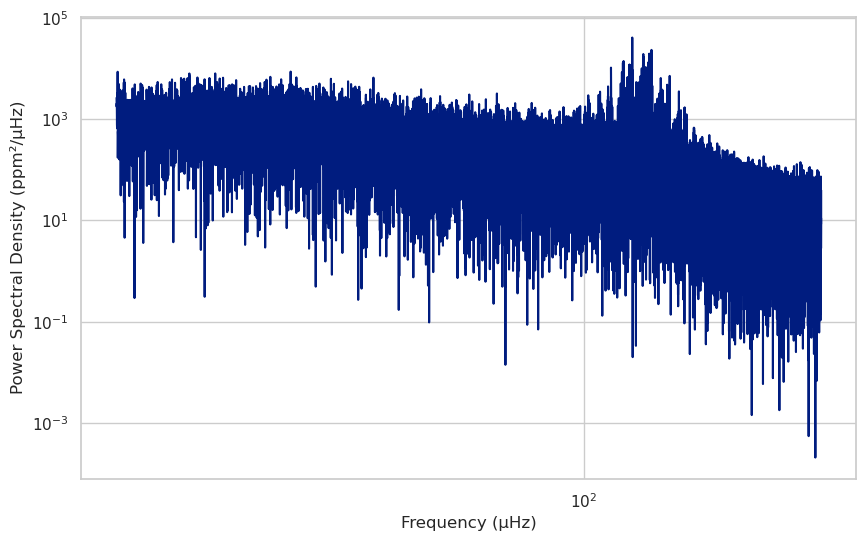

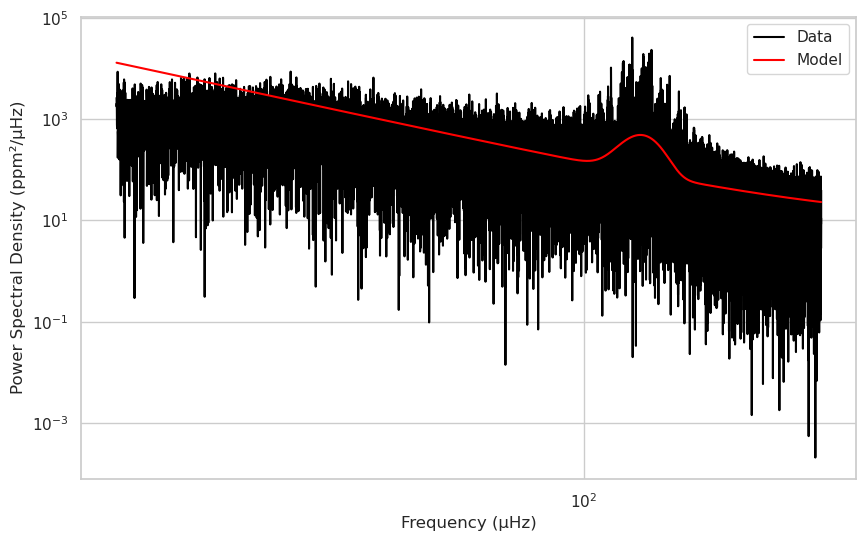

In [68]:
file = 'Kepler/spec_006144777.txt'

print(f"\n\nRunning file {file}")
sp = spectrum(file)
sp.plot_data()
sp.set_model(model, [sp.header["numax"], 10, 1e4, sp.header["background"][0], sp.header["background"][1], 10]) # numax, sigma, height, Bmax, beta, phot
sp.plot_model()


Running MCMC burn-in...


100%|██████████| 6000/6000 [03:45<00:00, 26.58it/s]


Running production MCMC...


100%|██████████| 3000/3000 [01:49<00:00, 27.39it/s]


Done


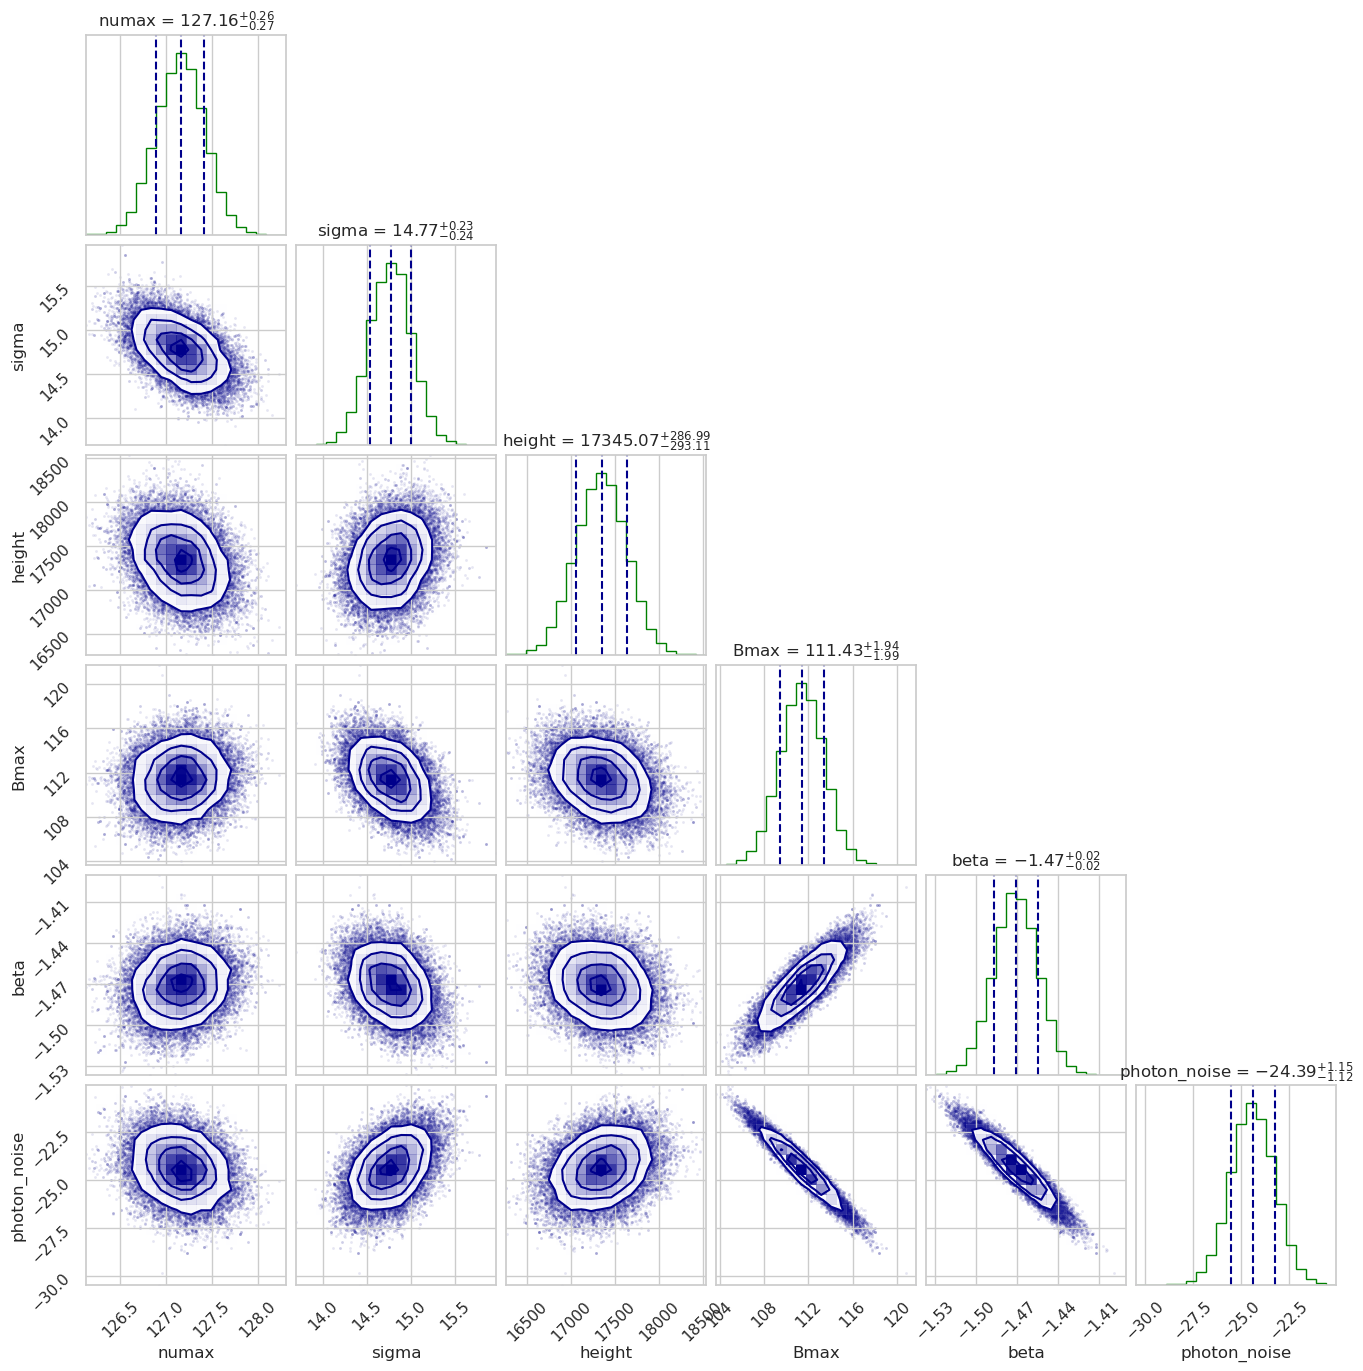

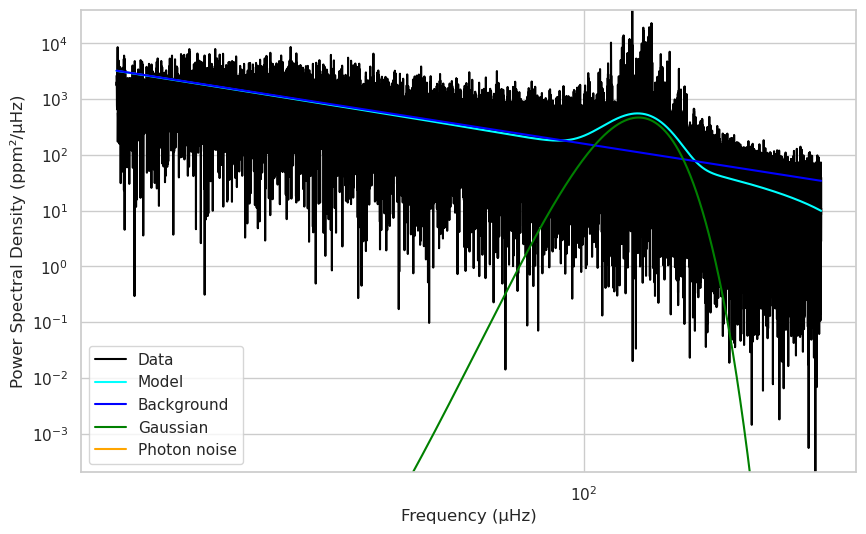


Initial parameters:
numax = 128.40 µHz
sigma = 10.00 µHz
height = 10000.00
Bmax = 76.03
beta = -2.23
photon_noise = 10.00

Best-fit parameters:
numax = 127.16 µHz
sigma = 14.77 µHz
height = 17345.07
Bmax = 111.43
beta = -1.47
photon_noise = -24.39


In [69]:
sp.init_mcmc_bg()
sp.run_mcmc_bg()
sp.get_samples_bg()
sp.plot_corner_bg()
# sp.set_params_bg(np.array([129.14088291,   9.99441104, 649.3121786 , 135.34202937, -1.33947591, -38.18226181]))
sp.plot_fit_bg()
sp.fitted_params_bg()

In [70]:
sp.clean_data()
numax = sp.best_params[0]

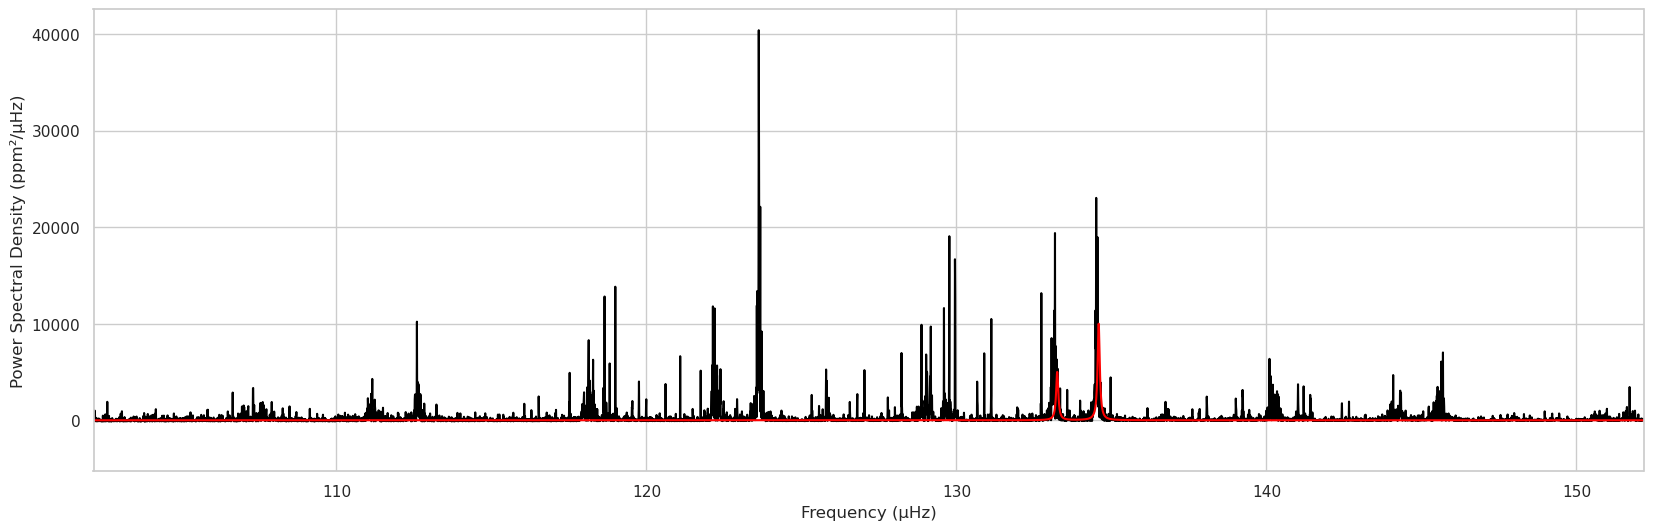

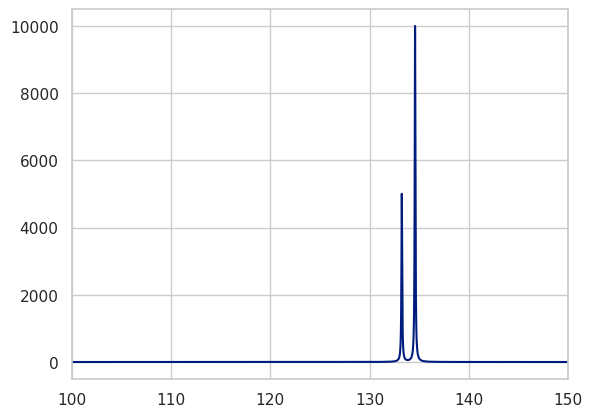

In [71]:
h1, h2 = 1e4, 0.5e4
lw1, lw2 = 0.085, 0.085
n = 11
sp.plot_clean_fit(h1, h2, lw1, lw2, sp.header["Dnu"], sp.header["epsilon"], sp.header["alpha"], -0.12, numax, n)
plt.plot(sp.frequency, l_peaks(sp.frequency, h1, h2, lw1, lw2, sp.header["Dnu"], sp.header["epsilon"], sp.header["alpha"], -0.12, numax, n))
plt.xlim(100, 150)
plt.show()


In [72]:
sp.init_mcmc_l([h1, h2, lw1, lw2, -0.12, sp.header["Dnu"]])
sp.run_mcmc_l(n, (131, 135))

Running MCMC...


100%|██████████| 100000/100000 [01:42<00:00, 971.84it/s]


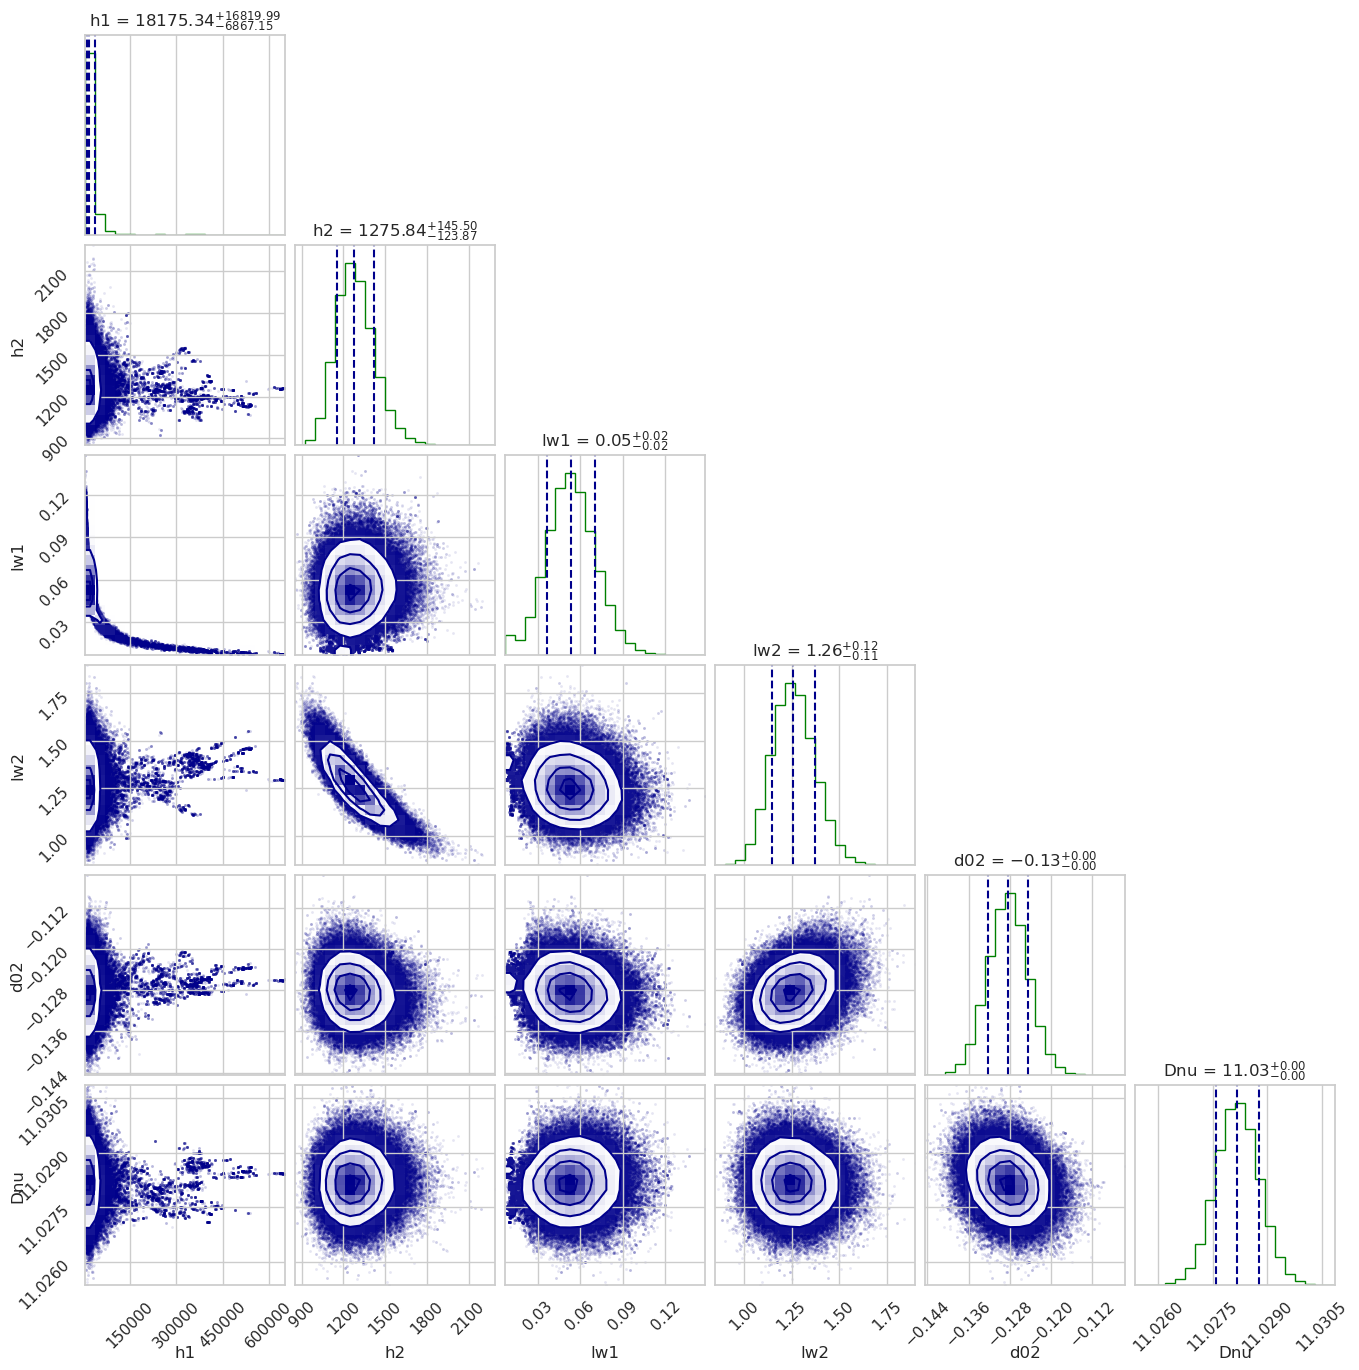

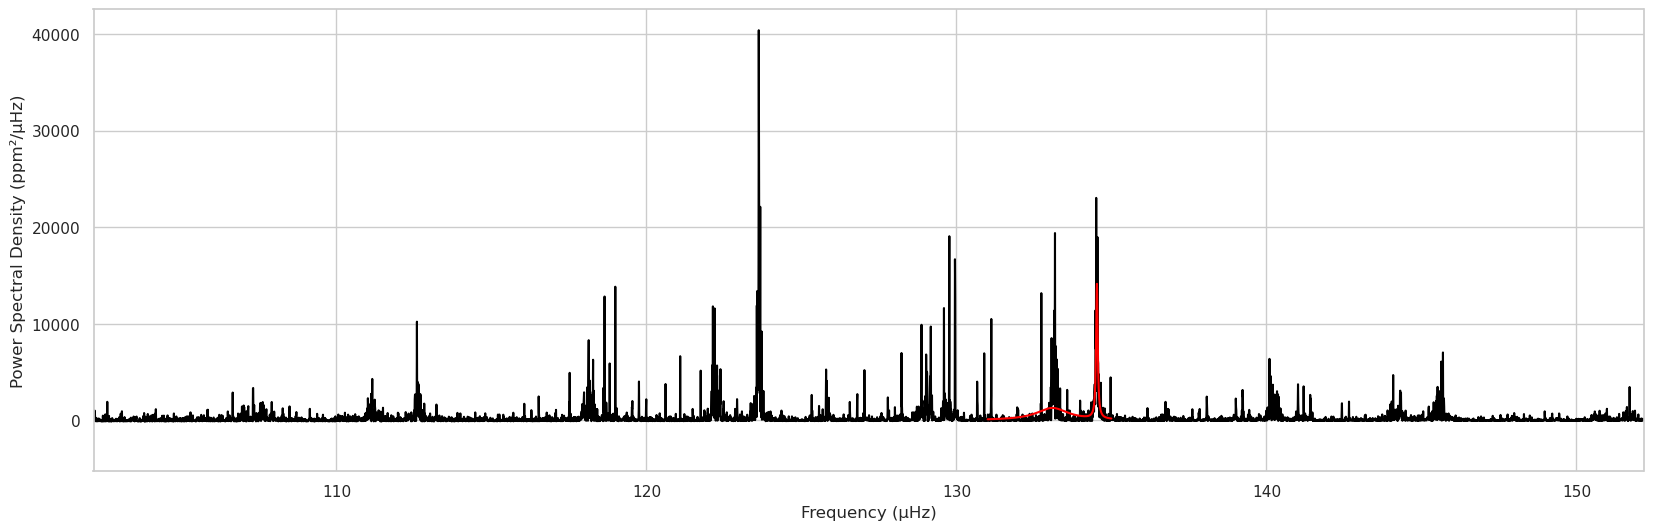

In [73]:
sp.get_samples_l()
sp.plot_corner_l(n)
sp.plot_fit_l(n)

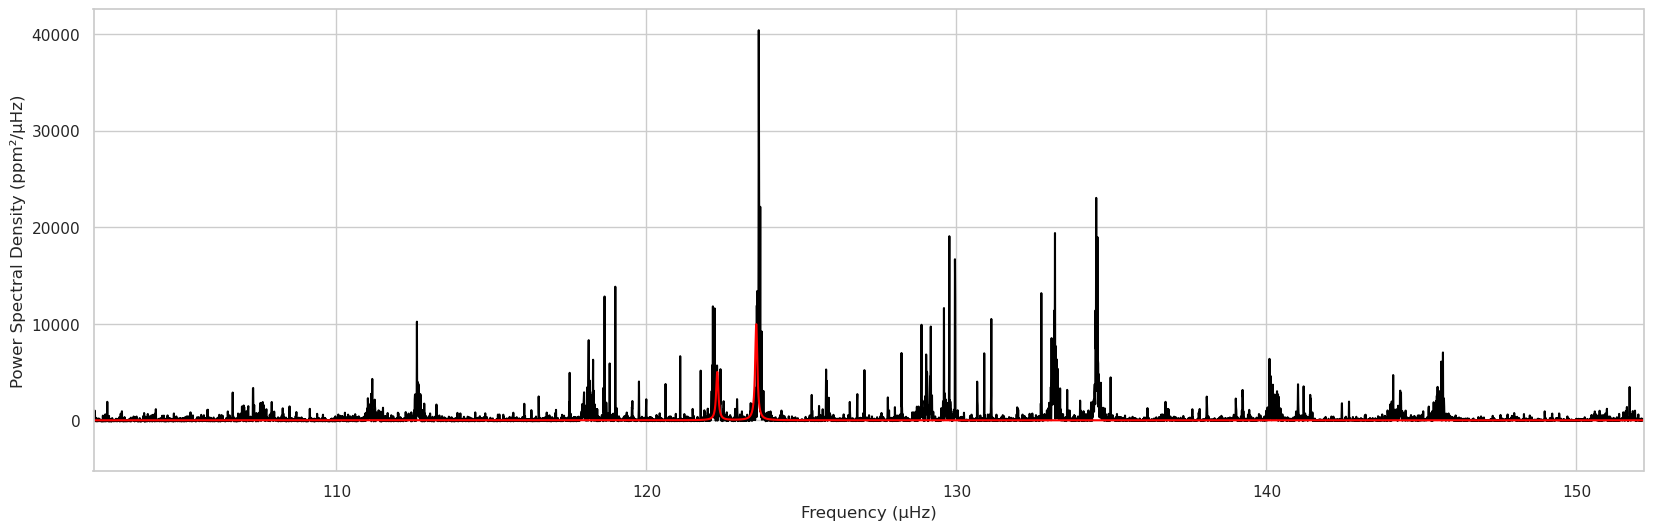

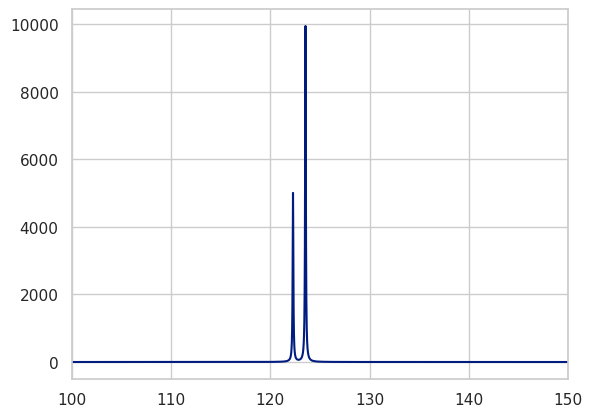

In [74]:
h1, h2 = 1e4, 0.5e4
lw1, lw2 = 0.085, 0.085
n = 10
sp.plot_clean_fit(h1, h2, lw1, lw2, sp.header["Dnu"], sp.header["epsilon"], sp.header["alpha"], -0.12, numax, n)
plt.plot(sp.frequency, l_peaks(sp.frequency, h1, h2, lw1, lw2, sp.header["Dnu"], sp.header["epsilon"], sp.header["alpha"], -0.12, numax, n))
plt.xlim(100, 150)
plt.show()

In [75]:
sp.init_mcmc_l([h1, h2, lw1, lw2, -0.12, sp.header["Dnu"]])
sp.run_mcmc_l(n, (120, 125))

Running MCMC...


100%|██████████| 100000/100000 [01:48<00:00, 918.84it/s]


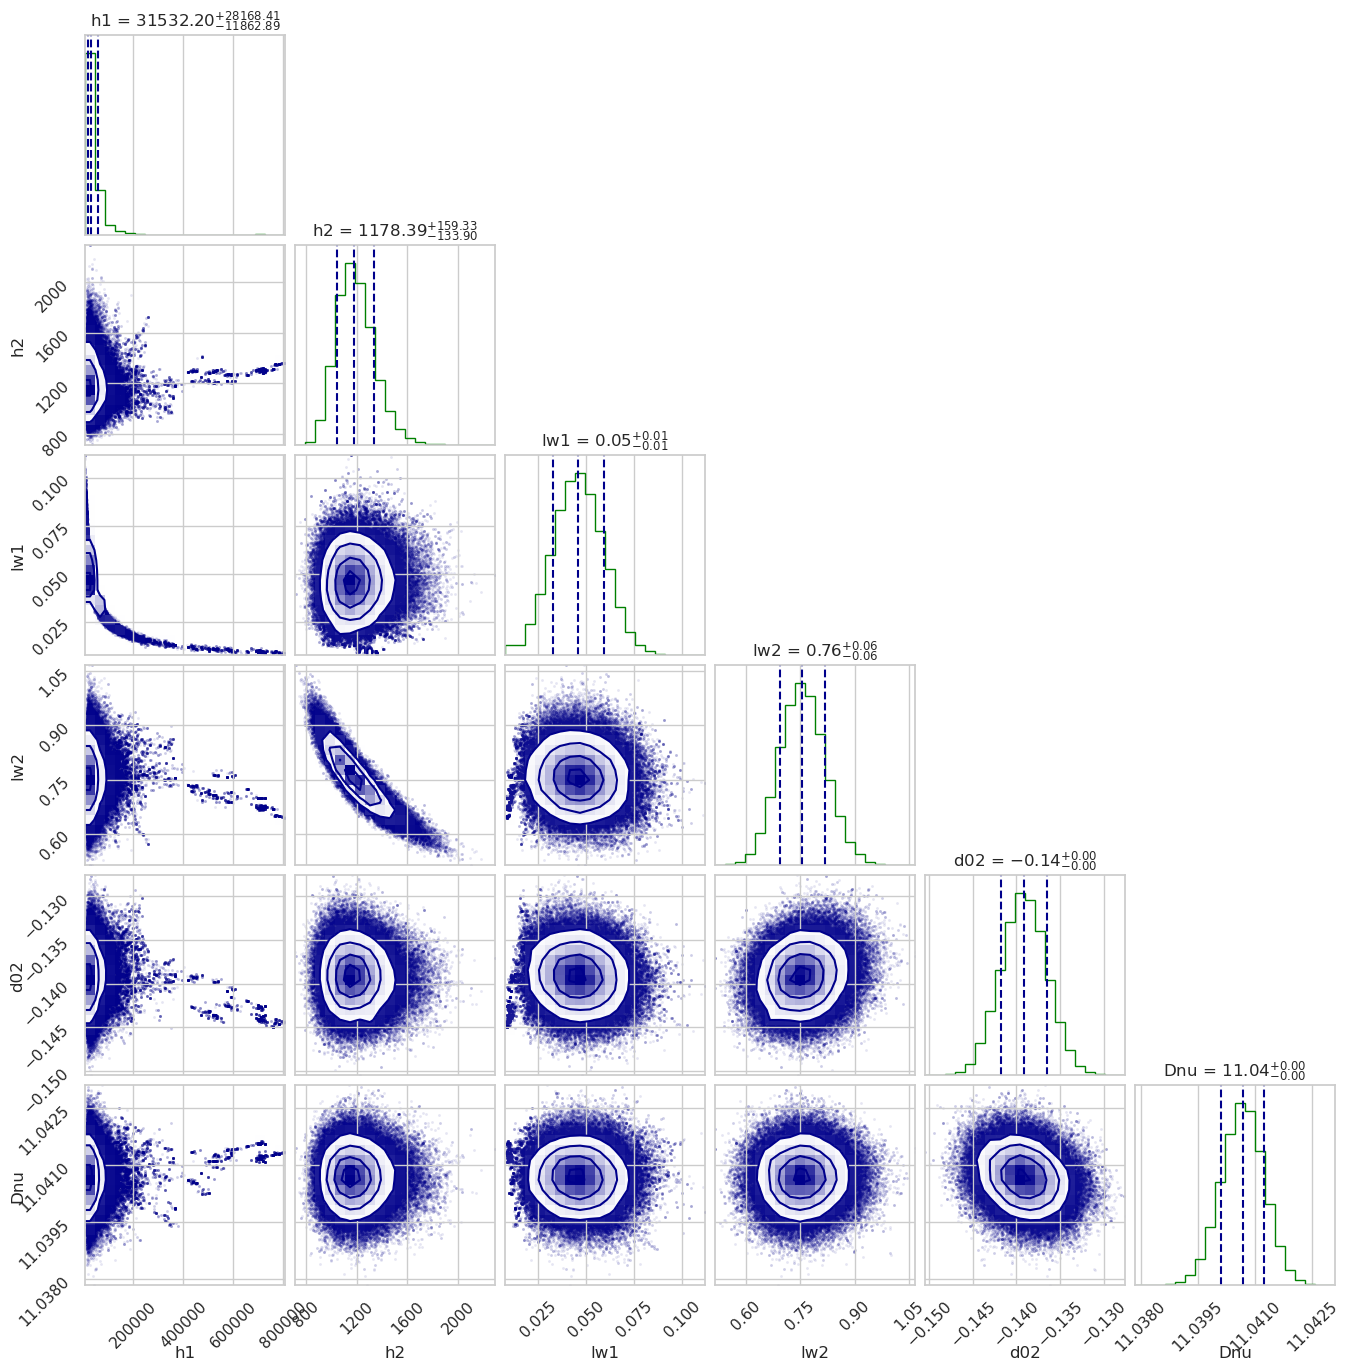

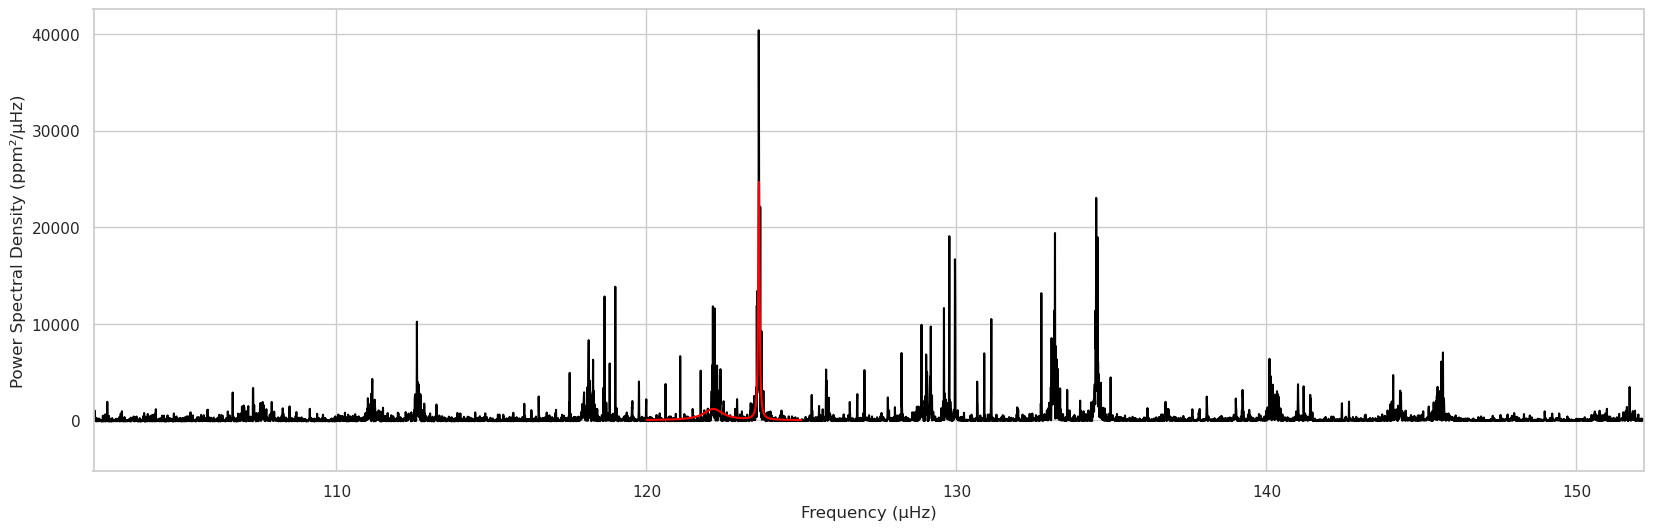

In [76]:
sp.get_samples_l()
sp.plot_corner_l(n)
sp.plot_fit_l(n)


In [77]:
nu10 = sp.get_nu_nl(10)
nu11 = sp.get_nu_nl(11)
Dnu_est = nu11 - nu10
print(f"Estimated Dnu: {Dnu_est:.2f} µHz")


Estimated Dnu: 11.06 µHz
